In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split #, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#from sklearn import preprocessing
from numpy import unravel_index
from matplotlib.colors import ListedColormap
from numpy import linspace
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

/Users/philipp/Python/anaconda3/envs/py3iaml/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/philipp/Python/anaconda3/envs/py3iaml/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/philipp/Python/anaconda3/envs/py3iaml/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy rele

# Classification
trying to train a model that can classify if weather data is from the northern third, the middle third or the southern third

In [2]:
# load data
path_file = os.path.join(os.getcwd(), 'data_weather_missing_values_filled.csv')
data = pd.read_csv(path_file)

In [3]:
# print the shape of the data and the first 5 instances
print(data.shape)
data.head()

(36795, 11)


,yyyy,mm,tmax,tmin,af,rain,sun,lat,lon,station,third
0,1942,1,5.8,2.1,10,114.0,58.0,52.139,-4.57,aberporth,1
1,1942,2,4.2,-0.6,14,13.8,80.3,52.139,-4.57,aberporth,1
2,1942,3,9.7,3.7,1,58.0,117.9,52.139,-4.57,aberporth,1
3,1942,4,13.1,5.3,0,42.5,200.1,52.139,-4.57,aberporth,1
4,1942,5,14.0,6.9,0,101.1,215.1,52.139,-4.57,aberporth,1


In [4]:
# descriptive statistics
data.describe()

,yyyy,mm,tmax,tmin,af,rain,sun,lat,lon,third
count,36795.000000,36795.000000,36795.000000,36795.000000,36795.000000,36795.000000,36795.000000,36795.000000,36795.000000,36795.000000
mean,1968.987118,6.487539,12.720948,5.917076,3.564805,73.083734,116.731480,53.962404,-2.716951,1.605816
std,35.990652,3.454615,5.041129,4.067206,5.247866,47.961228,68.378006,2.511071,2.207022,0.719221
min,1853.000000,1.000000,-4.700000,-9.700000,-6.000000,0.000000,-304.300000,50.218000,-6.880000,1.000000
25%,1949.000000,3.000000,8.500000,2.700000,0.000000,39.500000,63.000000,51.761000,-4.147000,1.000000
50%,1976.000000,6.000000,12.400000,5.500000,1.000000,63.000000,111.400000,53.381000,-2.584000,1.000000
75%,1997.000000,9.000000,16.800000,9.400000,6.000000,95.000000,162.600000,55.311000,-1.262000,2.000000
max,2019.000000,12.000000,28.300000,18.000000,33.000000,568.800000,823.400000,60.139000,1.727000,3.000000


       station  percent
third                  
1        19627     53.3
2        12045     32.7
3         5123     13.9
36795 masks


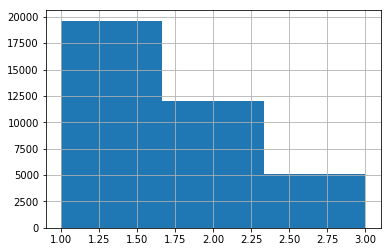

In [5]:
# plot the distribution of the weather data in the thirds
count_cat = data[['station', 'third']].groupby('third').count()
count_cat['percent'] = round(count_cat/count_cat.sum() * 100, 1)
print(count_cat)
data['third'].hist(bins=data['third'].max())
print(data.shape[0], 'masks')

comment:
the data is not balanced on the target attribute ('third'). 53% of the data fall into the southern third and just 14% fall into the nothern part

In [6]:
# count kinds of MA
temp = data[['tmax', 'third']].groupby('third').count()
temp = round(temp.min()/1000,1)*1000
temp = temp[0]

15300 masks


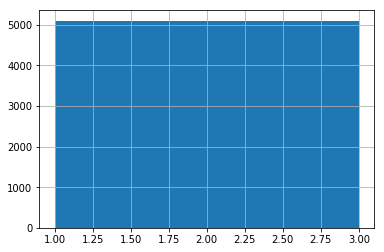

In [7]:
# make the data set blanced over the target variable ('third')
SAMPLES_PER_GROUP = int(temp)
data_balanced = data.groupby('third').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
data_balanced['third'].hist(bins=data_balanced['third'].max())
print(data_balanced.shape[0], 'masks')

comment: 
* to acomplish a balanced dataset on the target variable I had to get rid of 58% of the data
* I tried the alorithms and the full inbalanced dataset outperforms the balanced dataset

## prepare data
prepare data for using it in the classification algorithms

In [8]:
########################
###   shuffle data   ###
########################

data = data.reindex(np.random.permutation(data.index))

In [9]:
######################################
###   split into train-test data   ###
######################################

# split into train, validate, test
train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

comment:
I am splitting the data into:
* a training set -> for training the classifiers but classifiers can overfit to this dataset
* a validation set -> for selecting the best performing model
* but since I selected the bes performing model the score (accurancy is biased towards the model)
* a test set that shows the real performance of the selected model

In [10]:
##########################################
###   assingn attributes and targets   ###
##########################################

X_train = train[['yyyy', 'mm', 'tmax', 'tmin', 'af', 'rain', 'sun']].values
y_train = train['third'].values
X_val = validate[['yyyy', 'mm', 'tmax', 'tmin', 'af', 'rain', 'sun']].values
y_val = validate['third'].values
X_test = test[['yyyy', 'mm', 'tmax', 'tmin', 'af', 'rain', 'sun']].values
y_test = test['third'].values

In [11]:
############################
###   standardize data   ###
############################

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [12]:
# print shapes of full, training, validation and test set
print(data.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(36795, 11)
(22077, 7)
(7359, 7)
(7359, 7)


### appling PCA
applying PCA for dimensionality reduction since some algorithms perform better with data in a lower dimensional space

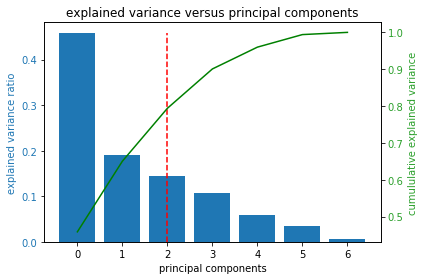

In [13]:
##############################################
###   PCA - Principal component analysis   ###
##############################################

# fit PCA
pca = PCA(n_components=X_train.shape[1], svd_solver='full')
pca.fit(X_train) # X

# make cumulative array of the variance
culm_var = np.cumsum(pca.explained_variance_ratio_)
    
# find 80%
idx_08 = (np.abs(culm_var-0.80)).argmin()

# make plot
fig, ax1 = plt.subplots()
plt.title('explained variance versus principal components')

# plot explained variance ratio
color = 'tab:blue'
ax1.set_xlabel('principal components')
ax1.set_ylabel('explained variance ratio', color=color)
ax1.bar(np.arange(X_train.shape[1]), pca.explained_variance_ratio_)
ax1.tick_params(axis='y', labelcolor=color)

# plot 80% of the variance is explained
ax1.vlines(idx_08, 0, pca.explained_variance_ratio_.max(), colors='k', linestyles='--', label='80%', color='r')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# plot cumative variance
color = 'tab:green'
ax2.set_ylabel('cumululative explained variance', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(X_train.shape[1]), culm_var, color='g')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

comment:
after applying PCA to the data and plotting the explained variance of the principal components, we can se that mor than 80% of the variance can be explained by just 2 principal components

In [14]:
#####################
###   apply PCA   ###
#####################

# define PCA
pca = PCA(n_components=idx_08, svd_solver='full')
# compute PCA
pca.fit(X_train)

# transform training and validation data set
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

## training classifiers
traing differn classifiers

In [15]:
############################
###   NB - Naive Bayes   ###
############################

Xs = [[X_train,X_val,'without PCA'],[X_train_pca,X_val_pca,'with PCA']]
for X in Xs:
    print("\n*****************   " + X[2] + "   *****************\n")
    gnb = GaussianNB()
    gnb.fit(X[0], y_train)
    pred = gnb.predict_proba(X[1])

    print("score:    {:.3f}".format(gnb.score(X[1],y_val)))
    print("log loss: {:.3f}".format(log_loss(y_val,pred))) 


*****************   without PCA   *****************

score:    0.516
log loss: 1.034

*****************   with PCA   *****************

score:    0.539
log loss: 0.947


In [16]:
####################################
###   LR - Logistic Regression   ###
####################################

# trying LR with solver: 'lbfgs', 'liblinear', 'newton-cg'
solvers = ['lbfgs', 'liblinear', 'newton-cg']

Xs = [[X_train,X_val,'without PCA'],[X_train_pca,X_val_pca,'with PCA']]
for X in Xs:
    print("\n*****************   " + X[2] + "   *****************\n")
    for solver in solvers:
        print("-----------------   solver: " + solver + "   -----------------")
        lr = LogisticRegression(solver=solver)
        lr.fit(X[0], y_train)
        pred = lr.predict_proba(X[1])

        print("score:    {:.3f}".format(lr.score(X[1],y_val)))
        print("log loss: {:.3f}".format(log_loss(y_val,pred)))


*****************   without PCA   *****************

-----------------   solver: lbfgs   -----------------
score:    0.558
log loss: 0.895
-----------------   solver: liblinear   -----------------
score:    0.558
log loss: 0.895
-----------------   solver: newton-cg   -----------------
score:    0.558
log loss: 0.895

*****************   with PCA   *****************

-----------------   solver: lbfgs   -----------------
score:    0.545
log loss: 0.951
-----------------   solver: liblinear   -----------------
score:    0.545
log loss: 0.951
-----------------   solver: newton-cg   -----------------
score:    0.545
log loss: 0.951


In [17]:
###########################################
###   SVC - Support Vector Classifier   ###
###########################################

import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

def ml_svc(kernel):
    svc = SVC(kernel=kernel, probability=True, gamma='auto')
    svc.fit(X[0], y_train)
    pred = svc.predict_proba(X[1])
    
    print("-----------------   kernel: " + kernel + "   -----------------")
    print("score:    {:.3f}".format(svc.score(X[1],y_val))) 
    print("log loss: {:.3f}".format(log_loss(y_val,pred)))
    
    return(pred)

pool = mp.Pool(processes=mp.cpu_count())

Xs = [[X_train,X_val,'without PCA'],[X_train_pca,X_val_pca,'with PCA']]
for X in Xs:
    print("\n*****************   " + X[2] + "   *****************\n")
    results = pool.map(ml_svc, ['poly', 'rbf', 'sigmoid', 'linear'])

Number of processors:  4

*****************   without PCA   *****************



KeyboardInterrupt: 

In [60]:
###########################################
###   SVC - Support Vector Classifier   ###
###########################################

# trying SVC with kernel: 'poly', 'rbf', 'sigmoid', 'linear'
kernels = ['poly', 'rbf', 'sigmoid', 'linear']

Xs = [[X_train,X_val,'without PCA'],[X_train_pca,X_val_pca,'with PCA']]
for X in Xs:
    print("\n*****************   " + X[2] + "   *****************\n")
    for kernel in kernels:
        print("-----------------   kernel: " + kernel + "   -----------------")
        svc = SVC(kernel=kernel, probability=True)
        svc.fit(X[0], y_train)
        pred = svc.predict_proba(X[1])

        print("score:    {:.3f}".format(svc.score(X[1],y_val))) 
        print("log loss: {:.3f}".format(log_loss(y_val,pred)))


*****************   without PCA   *****************

-----------------   kernel: poly   -----------------
score:    0.530
log loss: 0.962
-----------------   kernel: rbf   -----------------
score:    0.618
log loss: 0.818
-----------------   kernel: sigmoid   -----------------
score:    0.337
log loss: 1.094
-----------------   kernel: linear   -----------------


KeyboardInterrupt: 

In [25]:
#####################################
###   KNN - K-nearest neighbors   ###
#####################################

Xs = [[X_train,X_val,'without PCA'],[X_train_pca,X_val_pca,'with PCA']]
for X in Xs:
    print("\n*****************   " + X[2] + "   *****************\n")
    
    #trying KNN with K: 5 to 20
    for k in np.arange(5,20,2):
        print("-----------------   k: " + str(k) + "   -----------------")
        knc = KNeighborsClassifier(n_neighbors=k)
        knc.fit(X[0], y_train)
        pred = knc.predict_proba(X[1])

        print("score:    {:.3f}".format(knc.score(X[1],y_val))) 
        print("log loss: {:.3f}".format(log_loss(y_val,pred)))


*****************   without PCA   *****************

-----------------   k: 5   -----------------
score:    0.641
log loss: 3.137
-----------------   k: 7   -----------------
score:    0.643
log loss: 2.055
-----------------   k: 9   -----------------
score:    0.645
log loss: 1.532
-----------------   k: 11   -----------------
score:    0.648
log loss: 1.291
-----------------   k: 13   -----------------
score:    0.649
log loss: 1.158
-----------------   k: 15   -----------------
score:    0.645
log loss: 1.044
-----------------   k: 17   -----------------
score:    0.648
log loss: 0.963
-----------------   k: 19   -----------------
score:    0.646
log loss: 0.929

*****************   with PCA   *****************

-----------------   k: 5   -----------------
score:    0.523
log loss: 4.335
-----------------   k: 7   -----------------
score:    0.532
log loss: 2.885
-----------------   k: 9   -----------------
score:    0.531
log loss: 2.197
-----------------   k: 11   ---------------

In [19]:
##########################################
###   NN - Neural Network Classifier   ###
##########################################

# model
params = {'hidden_layer_sizes': [(4,), (8,), (16,), (32,), (64,), (128,), (4, 8, 4,), (16, 32, 16,)]}
mlp = MLPClassifier(verbose=False, learning_rate='adaptive', random_state=100)
clf = GridSearchCV(mlp, params, verbose=False, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

print('Finished with grid search with best mean cross-validated score:', clf.best_score_)
print('Best params appeared to be', clf.best_params_)

pred = clf.predict_proba(X_val)
print('score:    ', clf.score(X_val,y_val)) 
print('log loss: ', log_loss(y_val,pred))

Finished with grid search with best mean cross-validated score: 0.7019975540154912
Best params appeared to be {'hidden_layer_sizes': (16, 32, 16)}
score:     0.6977850251392852
log loss:  0.6716363373398718


In [17]:
alphas = [0.2]
for alpha in alphas:
    mlp = MLPClassifier(hidden_layer_sizes= (32, 64, 32,), max_iter=500, learning_rate='adaptive', learning_rate_init=0.001, alpha=alpha, random_state=100)
    mlp.fit(X_train,y_train)
    pred = mlp.predict_proba(X_val)
    
    print('------------------------   alpha: ' + str(alpha) + '   ------------------------')
    print(mlp.score(X_val,y_val)) 
    print(log_loss(y_val,pred))

------------------------   alpha: 0.2   ------------------------
0.6994156814784618
0.6650418687789978


In [18]:
alphas = [0.2]
for alpha in alphas:
    mlp = MLPClassifier(hidden_layer_sizes= (64, 128, 64), max_iter=500, learning_rate='adaptive', learning_rate_init=0.001, alpha=alpha, random_state=100)
    mlp.fit(X_train,y_train)
    pred = mlp.predict_proba(X_val)
    
    print('------------------------   alpha: ' + str(alpha) + '   ------------------------')
    print(mlp.score(X_val,y_val)) 
    print(log_loss(y_val,pred))

------------------------   alpha: 0.2   ------------------------
0.6988721293654029
0.6678639926256065


In [19]:
print(mlp.score(X_test,y_test))

0.7048512026090501


The best performing classifier is a fully connected neural network with a 64-128-64 architecture. It reaches an accurcy of 70% on the test set.